<a name="top"> <h1>3.3. Random Forest</h1> <a>

<p>Yelp Dataset- Stars Prediction<br />
<strong>Aprendizaje Autom&aacute;tico</strong><br />
<strong>Master Universitario en Ciencia de Datos</strong></p>

<p>&nbsp;</p>

<p style="text-align:right">Antonio Nogués Podadera (<em>antonio.nogues@cunef.edu</em>)</p>
<p style="text-align:right">V&iacute;ctor Viloria V&aacute;zquez (<em>victor.viloria@cunef.edu</em>)</p>

<hr style="border:1px solid gray">

### Estructura

[0. Introducción](#introduccion) 


[1. Importación de librerias y funciones](#librerias) 


[2. Carga de datos](#datos) 

[3. Creación del modelo](#creacion) 

   
[4. Optimización del modelo](#optimizacion) 

   
[5. Predicción del modelo](#prediccion)

[6. Evaluación de las métricas del modelo](#metricas)

   - Matriz de confusión
   - Métricas: Accuracy, Recall, Precision, F0.5, F1
   - Curva ROC y Lift

<hr style="border:1px solid gray">

# <a name="introduccion"> 0. Introducción <a> 

El método del Random Forest podría considerarse como una solución al arbol de decision, puesto que es muy inestable. En este caso el Random Forest ejecuta varios árboles de decision al mismo tiempo quedándose con la clase mayoritaria. A mayor número de árboles y mayor profundidad, más probabilidad habrá de que se cometa un overfiting. 

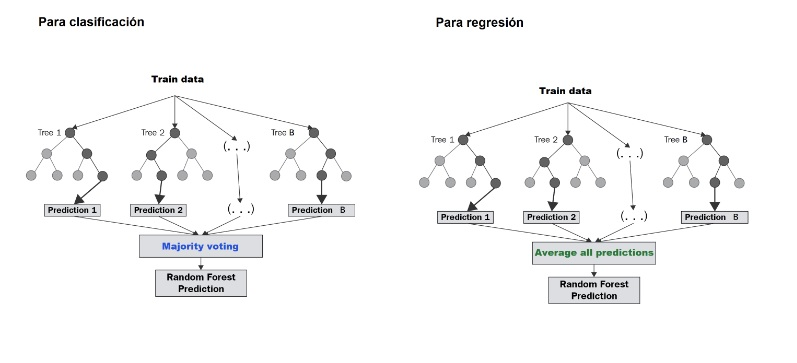

# <a name="librerias"> 1. Importación de librerias y funciones <a> 

In [1]:
# Import basic libraries.

import pandas as pd
import matplotlib.pyplot as plt
import pickle 
import scikitplot as skplt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# Import sklearn metrics.

from sklearn.metrics import plot_confusion_matrix, fbeta_score, roc_curve, classification_report,accuracy_score,roc_auc_score

# Import sklearn models, smote and pipeline.

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE 
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

Importamos las funciones a utilizar:

In [2]:
# Import the functions used in the notebook.

from aux_functions import load_model, save_model

Cargamos el pickle de preprocesado, para su posterior uso:

In [3]:
# Import the preprocessor.

preprocessor = load_model('../models/preprocessor.pickle')

# <a name="datos"> 2. Carga de datos <a> 

En primer lugar procederemos a cargar los datos de train y validación que insertaremos dentro del modelo para su optimización y predicción.

In [4]:
# Load the train dataset separated by other variables and target.

x_train = pd.read_parquet("../data/processed/x_train.parquet").reset_index(drop=True)
y_train = pd.read_parquet("../data/processed/y_train.parquet").reset_index(drop=True)

# Load the validation dataset separated by other variables and target.

x_val = pd.read_parquet("../data/processed/x_val.parquet")
y_val = pd.read_parquet("../data/processed/y_val.parquet")

# <a name="creacion"> 3. Creación del modelo <a> 

Para la creación del modelo, **utilizaremos un modelo Random Forest** con el parámetro de balanceo, con el objetivo de conseguir unos mejores scores.

In [5]:
# Hard coded variables

n_jobs = -1
random_state = 12345
class_weight = 'balanced'


# Creation of a pipeline that applies a preprocess of the data and then Random Forest

random_forest = Pipeline([
    ('preprocessor', preprocessor),
    ('clasificador', RandomForestClassifier(random_state=random_state, n_jobs=n_jobs, class_weight=class_weight))
    
])

# <a name="optimizacion"> 4. Optimización del modelo <a> 

Optimizamos el modelo a través del pipeline creado anteriormente, para ello introduciremos los valores de train.

In [6]:
# Optimization of the random forest model with the train set: input and target data. 

random_forest.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('short_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['attributes_ByAppointmentOnly',
                                                   'attributes_BusinessAcceptsCreditCards',
                                                   'attributes_BikeParking',
                                                   'attributes_RestaurantsPriceRange2',
                                                   'attributes_...
                                                   'attributes_AgesAllowed']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['review_count',
                                                   'total_hours_Monday',
                                                   'total_hours_Tuesday',
                                                   'total_hours_Wednesday',
                                                   'total_hours_Thursday',
                                                   'total_hours_Friday',
                                                   'total_hours_Saturday',
                                                   'total_hours_Sunday',
                                                   'total_checkins'])])),
                ('clasificador',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=12345))])

Una vez optimizado el modelo Random Forest, con el set de train, procedemos a guardarlo en un pickle para que no tenga que volver a computarlo en un futuro, por si quisieramos usarlo.

In [7]:
# Save the backup of the dummy optimziation as a pickle file.

save_model(random_forest,'../models/Random_Forest.pickle')

Para evitar ejecutar de nuevo el modelo, ejecutar a partir de la celda que aparece a continuación.

In [6]:
# Load the random forest model already fitted in /models.

random_forest = load_model('../models/Random_Forest.pickle')

# <a name="prediccion"> 5. Predicción del modelo <a> 

Una vez realizada la optimización del modelo Random Forest, procederemos a predecir el set de validación, sus valores y probabilidades. Para posteriormente obtener las métricas y observar cómo se comporta el modelo y su score.

In [7]:
# Predict target value of the validation set.

predictions = random_forest.predict(x_val)

# Predict probabilities of target value for validation set.

predict_probabilities = random_forest.predict_proba(x_val)

Una vez obtenidas las probabilidades, representamos el histograma de densidad de la predicción:

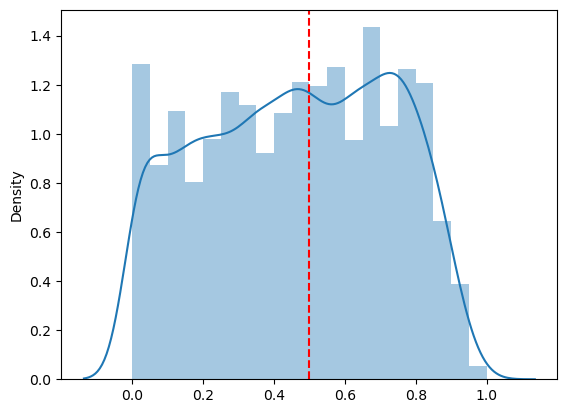

In [8]:
# Parametric density histogram of the predicted probabilities, shwoing the treshold of 0.5.

sns.distplot(predict_probabilities[:,1], kde=True, rug=False, bins=20)
plt.axvline(x=0.5, color='r', linestyle='--')
plt.show()


Observando el histograma de densidad de las probabilidades observamos como el modelo asigna un mayor número de observaciones probabilidades bajas.

# <a name="metricas"> 6. Evaluación de las métricas del modelo <a> 

En este apartado procederemos a análizar las métricas obtenidas. Nos centraremos principalmente en la métrica F0.5 , dado que es la que mejor refleja los resultados del modelo para nuestro problema. En el caso de que se quiera consultar la definición de cada una de ellas, se pueden encontrar en el documento `02_DummyModel`. 

### 6.1. Matriz de confusión

Confusion matrix, without normalization
[[2639  786]
 [ 865 2182]]
Normalized confusion matrix
[[0.77051095 0.22948905]
 [0.28388579 0.71611421]]


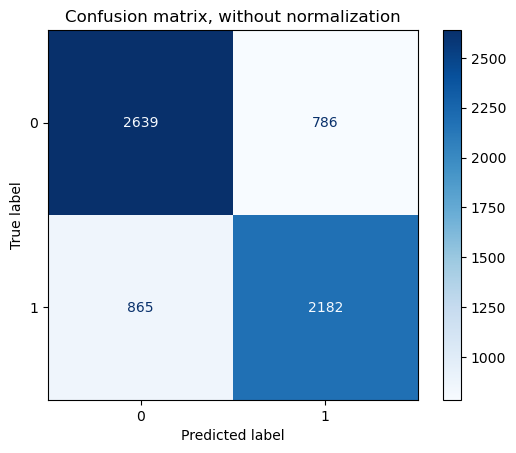

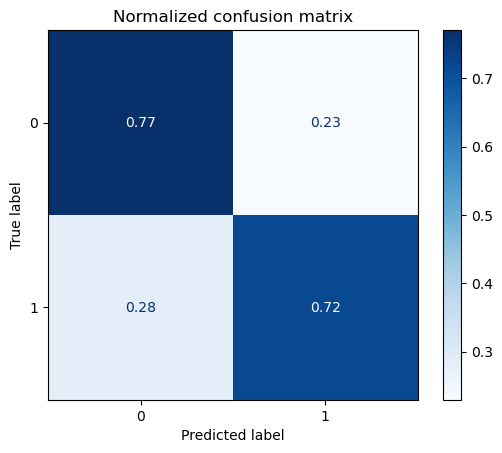

In [9]:
# List with the titles and parameters

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

# Plot the confusion matrix

for title, normalize in titles_options:
    disp = plot_confusion_matrix(random_forest, x_val, y_val,
                                 # display_labels=ytest,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

La matriz de confusión nos deja ver que la clase 1, que es la que nos interesa puesto que queremos identificar si va a obtener una puntuación alta de estrellas, tiene buenos resultados puesto que es capaz de identificar un **72%** de los casos.

### 6.2. Métricas: Accuracy, Recall, Precision, F0.5 y F1 score

In [10]:
# Print the general metrics.

print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76      3425
           1       0.74      0.72      0.73      3047

    accuracy                           0.74      6472
   macro avg       0.74      0.74      0.74      6472
weighted avg       0.74      0.74      0.74      6472



In [12]:
# Model Accuracy

print("Accuracy:",accuracy_score(y_val, predictions))

# F 0.5 score.

print('F0.5 score is ' +str(fbeta_score(y_val, predictions, average='binary', beta=0.5)))

Accuracy: 0.7449011124845488
F0.5 score is 0.7312822575239628


Para poder reflejar la capacidad predictora del modelo utilizaremos el Accuracy, Recall y F0.5 score.

- El modelo nos calcula un **Recall de 0.74**, por lo que el modelo es capaz de identificar un 74% de casos en los que hay una valoración alta. 


- El modelo nos calcula un **Accuracy de 0.74**, por lo que el modelo es capaz de acertar en el 74% de los casos. 


- **El modelo nos calcula un F0.5 de 0.73, por lo que el modelo es capaz de diferenciar falsos positivos en el 73% de los casos. Ligeramente superior a la regresión logística. Esta medida es la que utilizaremos para compararlo con el resto de modelos**

Las métricas son similares al modelo Logistic Regression, aunque han mejorado en el Accuracy.

### 6.3. Curva ROC y Lift

Para evaluar nuestro modelo, la representaremos graficamente para deducir que tan bueno es el modelo.

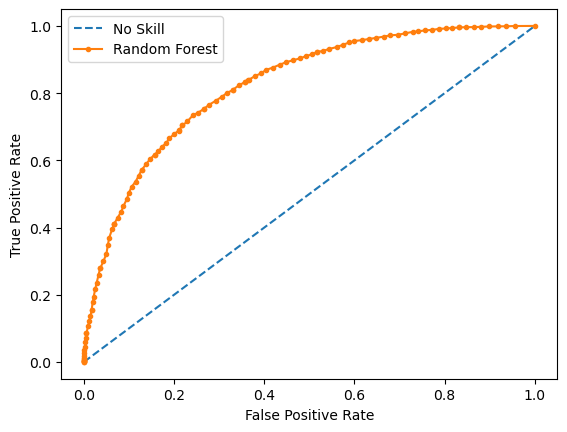

The Compute Area Under the Receiver Operating Characteristic is 0.8248832524033451


In [14]:
# Keep probabilities for the positive outcome only
yhat = predict_probabilities[:, 1]
# Calculate roc curves
fpr, tpr, thresholds = roc_curve(y_val, yhat)
# Plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# Show the plot
plt.show()

# Display the ROC AUC.

print('The Compute Area Under the Receiver Operating Characteristic is '+ str(roc_auc_score(y_val,yhat)))

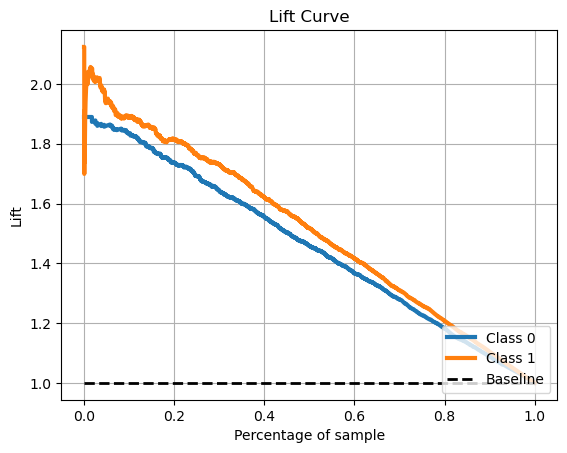

In [16]:
# Plot the lift curve.

skplt.metrics.plot_lift_curve(y_val, predict_probabilities)
plt.show()

 **La curva ROC muestra un resultado ligeramente superior a la regresión logística, pues el área de la curva es de 0.82.** 

 En cuanto a la curva lift, podemos observar que el modelo es similar, puesto que la elevación comienza en un nivel alto (2) y va descendiendo hasta la linea de identidad con el 100% de muestra utilizado.

[Ir arriba del documento](#top)